# Segment then align images
Our microscopy images drift signficiantly over time, which frustrates us being able to study how voids move between images.

In [1]:
%matplotlib inline
from rtdefects.segmentation.pytorch import PyTorchSemanticSegmenter
from rtdefects.drift import compute_drift_from_image_pair, compute_drifts_from_images, compute_drifts_from_images_multiref, subtract_drift_from_images
from rtdefects.analysis import analyze_defects
from rtdefects.io import encode_as_tiff
from matplotlib import pyplot as plt
from functools import lru_cache
from imageio import v3 as iio
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil

/home/lward/miniconda3/envs/rtdefects/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Configuration

In [2]:
run_directory = '../../../learning-defect-pde/data/8bitTIFF-video32-625C/'
frames_per_drift_point: int = 2  # Decrease to increase the complexity of drift model

Initialize the output directory

In [3]:
run_directory = Path(run_directory)
out_directory = Path('output') / run_directory.name
out_directory.mkdir(exist_ok=True, parents=True)
(out_directory / 'figures').mkdir(exist_ok=True)

Make a cached function for reading images

In [4]:
imread_fun = lru_cache()(iio.imread)

## Segment the Images and Save Masks to Disk
Segmentation produces a mask that contains the extent of each instance

In [5]:
images = sorted((run_directory).glob('*tif'))
print(f'Found {len(images)} images')

Found 860 images


Prepare to store segmented images and binary masks

In [6]:
out_directory

PosixPath('output/8bitTIFF-video32-625C')

In [7]:
segmented_dir = out_directory / 'segmented'
mask_dir = out_directory / 'mask'
for d in [segmented_dir, mask_dir]:
    if d.exists():
        shutil.rmtree(d)
    d.mkdir()

In [8]:
segmenter = PyTorchSemanticSegmenter()

In [9]:
defect_details = []
for image in tqdm(images):
    # Run segmentation
    image_data = iio.imread(image)
    image_data = segmenter.transform_standard_image(image_data)
    segmented = segmenter.perform_segmentation(image_data)

    # Save and analyze segmented image
    defect_details.append(analyze_defects(segmented))
    segmented_path = segmented_dir / image.with_suffix('.tiff').name
    defect_details[-1]['image_path'] = str(image)
    defect_details[-1]['segmented_path'] = str(segmented_path)
    segmented_path.write_bytes(encode_as_tiff(segmented))

    # Save a binary mask
    mask = segmented.any(axis=0)
    mask_path = mask_dir / image.with_suffix('.tiff').name
    defect_details[-1]['mask_path'] = str(mask_path)
    mask_path.write_bytes(encode_as_tiff(mask))
defect_details = pd.DataFrame(defect_details)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 860/860 [07:28<00:00,  1.92it/s]


## Determine the correction
The idea is to determine drift by computing the [cross-correlation between the two images](https://en.wikipedia.org/wiki/Cross-correlation#/media/File:Cross_correlation_animation.gif). 
The largest peak in the cross-correlation will correspond to the translation that leads to the greatest overlap between the two images.
Due to same [math I don't understand](https://en.wikipedia.org/wiki/Discrete_Fourier_transform#Circular_convolution_theorem_and_cross-correlation_theorem), you can compute this cross-correlation very quickly using Fourier Transforms with [SciPy](https://stackoverflow.com/questions/24768222/how-to-detect-a-shift-between-images).

In [10]:
images = defect_details['mask_path']

In [11]:
image_1 = imread_fun(images[0])
image_2 = imread_fun(images[16])

In [12]:
drift, conv = compute_drift_from_image_pair(image_1, image_2, return_conv=True)
drift

array([ 4, 12])

We can see the image drifted to the left (-x) and down (y)

In [13]:
image_2_shift = subtract_drift_from_images([image_2], drift[None, :])[0]  # Function operates on a list

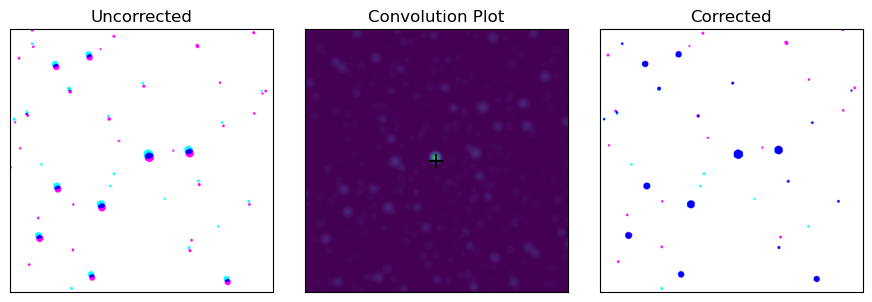

In [14]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3),)

for ax in axs:
    ax.set_yticks(ax.set_xticks([]))

# Plot the original and new overlapped
image = np.zeros((*image_1.shape[-2:], 3), dtype=np.uint8) + 255
image[:, :, 0] -= np.array(image_1, dtype=np.uint8)
image[:, :, 1] -= np.array(image_2, dtype=np.uint8)
axs[0].imshow(image)
axs[0].set_title('Uncorrected')

# Plot the convolution
axs[1].scatter([image_1.shape[1] // 2], [image_1.shape[0] // 2], marker='+', s=100., color='k')
axs[1].imshow(conv)
axs[1].set_title('Convolution Plot')

# Plot the re-registered images
image = np.zeros((*image_1.shape[-2:], 3), dtype=np.uint8) + 255
image[:, :, 0] -= np.array(image_1, dtype=np.uint8)
image[:, :, 1] -= np.array(image_2_shift, dtype=np.uint8)
axs[2].imshow(image)
axs[2].set_title('Corrected')

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-correlation.png', dpi=320)

The light and dark blue in the left image are the voids at different times. You can see the pattern drifts "up to the right" between them, which is reflected in the peak of the cross-correlation being up and to the right. 
Applying that transformation yields the two mapped directly atop each other.

## Apply to the whole stack
We can now compute the drift between successive images in the stack to get the total drift over time

In [15]:
%%time
all_masks = [imread_fun(p) for p in defect_details['mask_path']]

CPU times: user 997 ms, sys: 563 ms, total: 1.56 s
Wall time: 872 ms


In [16]:
%%time
total_drift = compute_drifts_from_images(all_masks)

CPU times: user 59.2 s, sys: 34.7 s, total: 1min 33s
Wall time: 1min 33s


Plot how the drift goes over time.

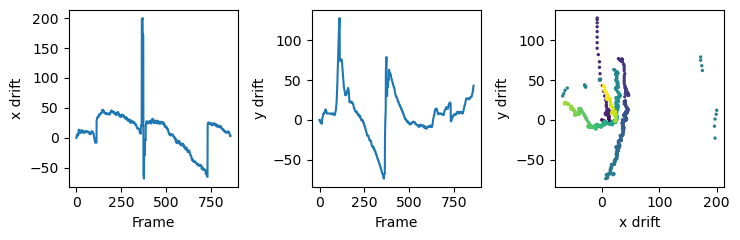

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5))

for ax, i, l in zip(axs, range(2), ['x', 'y']):
    ax.plot(total_drift[:, 1- i])
    ax.set_xlabel('Frame')
    ax.set_ylabel(l + ' drift')

axs[2].scatter(total_drift[:, 1], total_drift[:, 0], c=np.arange(total_drift.shape[0]), s=2)
axs[2].set_xlabel('x drift')
axs[2].set_ylabel('y drift')

# Plot the drifts
for ax in axs:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-from-fft.png', dpi=320)

This gives a quick estimate of drift by looking at individual pairs. One thing you will note are strong "jumps" between frames.

## Looking ahead multiple frames
The drift might be imperceptable between between adjacent frames but clearer for those far apart.
Judging image drift with frames several spaces apart will be able to give a better estimate, but at the expense of worse 

In [18]:
offsets = list(range(0, 20, 5))
drifts = [
    compute_drift_from_image_pair(image_1, imread_fun(images[i]))
    for i in tqdm(offsets)
]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.96it/s]


In [19]:
drifts = np.array(drifts)

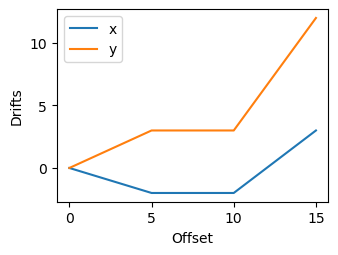

In [20]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

ax.plot(offsets, drifts[:, 0], label='x')
ax.plot(offsets, drifts[:, 1], label='y')

ax.set_xlabel('Offset')
ax.set_ylabel('Drifts')
ax.legend()

The drift is probably nonlinear given that the drifts to not change linearly with offset. So, it is not likely that we can just assume the drift 1 step ahead is $1/N$ times the difference.

## Multi-Reference Point Drift Evaluation
Instead of relying on measuring the drift at each frame, we are going to fit a single function which explains the observed drift between many pairs of frames.
This will make it possible to include drifts computed between frames which are farther apart, where the estimates of drift are more accurate.

We do that by measuring the drift between many pairs of images at different offsets then finding a single drift for each image which explains all measurements equally well.
The source code goes into more detail, but the short version is that we treat each drift measurement as a different linear equation

$\delta d_{i,j} = d_j - d_i$

where $\delta d_{i,j}$ is a relative drift and $d_i$ is the drift for a certain image.
We make a bunch of these measements and solve the resultant system of linear equations using linear least squares.

In [21]:
%%time
multiref_drift = compute_drifts_from_images_multiref(all_masks, offsets=(1, 2, 4, 8, 16), pbar=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4269/4269 [05:59<00:00, 11.89it/s]

CPU times: user 6min, sys: 869 ms, total: 6min 1s
Wall time: 5min 59s


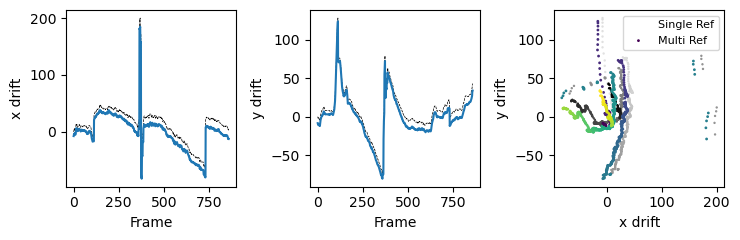

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.5))

for ax, i, l in zip(axs, range(2), ['x', 'y']):
    ax.plot(total_drift[:, 1- i], 'k--', lw=0.5)
    ax.plot(multiref_drift[:, 1- i], '-')
    ax.set_xlabel('Frame')
    ax.set_ylabel(l + ' drift')

axs[2].scatter(total_drift[:, 1], total_drift[:, 0], c=np.arange(total_drift.shape[0]), s=0.5, cmap='gray_r', label='Single Ref')
axs[2].scatter(multiref_drift[:, 1], multiref_drift[:, 0], c=np.arange(total_drift.shape[0]), s=1, label='Multi Ref')
axs[2].set_xlabel('x drift')
axs[2].set_ylabel('y drift')
axs[2].legend(fontsize=8)

# Plot the drifts
for ax in axs:
    ax.set_xlim(ax.get_xlim())
    ax.set_ylim(ax.get_ylim())

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-from-fft-multi-refrence.png', dpi=320)

Adjust the masks using the drift

In [23]:
shifted_masks = subtract_drift_from_images(all_masks, multiref_drift)

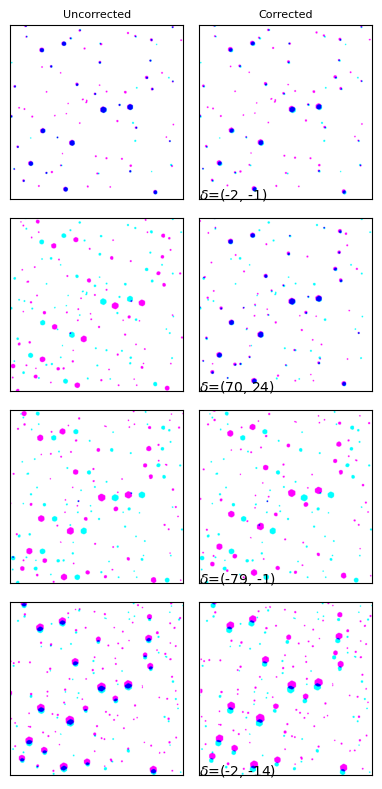

In [24]:
fig, axxs = plt.subplots(4, 2, figsize=(4, 8))


axxs[0, 0].set_title('Uncorrected', fontsize=8)
axxs[0, 1].set_title('Corrected', fontsize=8)

for axs, (ind_1, ind_2) in zip(axxs, [(30, 60), (60, 120), (120, 240), (240, 480)]):
    # Load the masks
    image_1 = all_masks[ind_1]
    image_2 = all_masks[ind_2]
    
    # Estimate the relative drift
    drift = multiref_drift[ind_2] - multiref_drift[ind_1]
    
    for ax in axs:
        ax.set_yticks(ax.set_xticks([]))

    # Plot the original and new overlapped
    image = np.zeros((*image_1.shape[-2:], 3), dtype=np.uint8) + 255
    image[:, :, 0] -= image_1
    image[:, :, 1] -= image_2
    axs[0].imshow(image)

    # Plot the re-registered images
    image = np.zeros((*image_1.shape[-2:], 3), dtype=np.uint8) + 255
    image_2_shift = shifted_masks[ind_2]
    image[:, :, 0] -= image_1
    image[:, :, 1] -= image_2_shift
    axs[1].imshow(image)
    axs[1].text(0, 0, f'$\delta$=({drift[0]:.0f}, {drift[1]:.0f})', transform=axs[1].transAxes)
    
    

fig.tight_layout()
fig.savefig(out_directory / 'figures/drift-correlation-multi-reference.png', dpi=320)

## Save Updated Model
Save it to disk for later use

In [26]:
out_path = out_directory / 'drifts-fft.csv'
pd.DataFrame(multiref_drift, columns=['x', 'y']).to_csv(out_path, index_label='frame')

## Update the Void Locations
The void locations in the defect details files with the run should be updated too.

In [27]:
defect_details['positions_corrected-fft'] = [(x - y) if len(x) > 0 else x for x, y in zip(defect_details['positions'], multiref_drift)]
defect_details['drift'] = total_drift.tolist()

In [28]:
defect_details.to_json(out_directory / f'defect-details.json', orient='records', lines=True)